In [1]:
import pandas as pd
from cartopy import crs as ccrs
import xarray as xr
from xhistogram.xarray import histogram
import numpy as np
# import gfdl_utils as gu
import glob
import re
from scipy.interpolate import griddata
import geopy
import cmocean.cm as cmo
import cmocean
import gsw
from geopy import distance
import xesmf as xe
# import sectionate
import sys
sys.path.insert(0, '/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/src')
from src import *
import seaborn as sns
sns.set_style("whitegrid")

import matplotlib.pyplot as plt
import matplotlib as mpl

dpi = 200
mpl.rcParams['figure.dpi'] = dpi
sns.set_context("notebook")

In [2]:
import sys
sys.path.insert(0, '/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/src')
from src import *
from Streamfunctions import *

In [99]:
# GLODAP:model variable naming conventions
model2glodap_names = {'cfc12':'cfc12','cfc11':'cfc11','sf6':'sf6','thetao':'theta','so':'salinity'}
variable_kwargs = {
    'cfc12':{'conversion':1e12/1035,'cmap':'Greens','units':'pmol kg-1'},
    'cfc11':{'conversion':1e12/1035,'cmap':'PuRd','units':'pmol kg-1'},
    'sf6':{'conversion':1e12/1035 * 1e3,'cmap':'Blues','units':'fmol kg-1'},
    'theta':{'conversion':1,'cmap':cmocean.cm.thermal,'units':'degK','bins':np.arange(-2,35,0.2),'anombins':np.arange(-4,4.05,0.05)},
    'thetao':{'conversion':1,'cmap':cmocean.cm.thermal,'units':'deg C','bins':np.arange(-2,35,0.2),'anombins':np.arange(-4,4.05,0.05)},
    'agessc':{'conversion':1,'cmap':cmocean.cm.thermal,'units':'deg C','bins':np.arange(-2,35,0.2),'anombins':np.arange(-4,4.05,0.05)},
    'salinity':{'conversion':1,'cmap':cmocean.cm.haline,'units':'psu','bins':np.arange(32,37,0.05),'anombins':np.arange(-1,1.02,0.02)}
}

variable_anom_kwargs = {
    'cfc12':{'conversion':1e12/1035,'cmap':'Greens','units':'pmol kg-1'},
    'cfc11':{'conversion':1e12/1035,'cmap':'PuRd','units':'pmol kg-1'},
    'sf6':{'conversion':1e12/1035 * 1e3,'cmap':'Blues','units':'fmol kg-1'},
    'theta':{'conversion':1,'cmap':cmocean.cm.thermal,'units':'degK','bins':np.arange(-2,35,0.2),'anombins':np.arange(-4,4.05,0.05)},
    'thetao':{'conversion':10,'cmap':cmocean.cm.thermal,'units':'deg C','bins':np.arange(-2,35,0.2),'anombins':np.arange(-4,4.05,0.05)},
    'agessc':{'conversion':1,'cmap':cmocean.cm.thermal,'units':'deg C','bins':np.arange(-2,35,0.2),'anombins':np.arange(-4,4.05,0.05)},
    'salinity':{'conversion':1,'cmap':cmocean.cm.haline,'units':'psu','bins':np.arange(32,37,0.05),'anombins':np.arange(-1,1.02,0.02)}
}


In [4]:
expt_colors = dict(); expt_colors["control"] = "#2f74b3"; expt_colors["forced"] = "#cc415a"


In [5]:
datadir = lambda x="" : "/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/model/" + x

In [6]:
ds_forced = xr.open_dataset(datadir("Glob_Zonal_Avg_Tracer_forced.nc"))
ds_ctrl = xr.open_dataset(datadir("Glob_Zonal_Avg_Tracer_control.nc"))
ds_ctrl.coords["time"] = ds_forced.time.values

In [28]:
ds_forced_mean = ds_forced.sel(time = slice("2050", None)).mean("time")
ds_ctrl_mean = ds_ctrl.sel(time = slice("2050", None)).mean("time")

ds_forced_mean["geolat"] = ds_forced["geolat"]
ds_ctrl_mean["geolat"] = ds_ctrl["geolat"]

In [105]:
#define sigma levels
siglevels = np.arange(36.2, 37.4, .2) 
siglevels = 1.0 * np.sort(np.append(siglevels, [36.9, 37.1, 37.11, 37.21, 37.22, 37.23, 37.24]))
siglevels


array([36.2 , 36.4 , 36.6 , 36.8 , 36.9 , 37.  , 37.1 , 37.11, 37.2 ,
       37.21, 37.22, 37.23, 37.24])

In [109]:
def plot_density_contours(ds, ax, min_lat = -60, linestyles = "-"): 
    # Add density contours for control (solid black lines)
    ds_crop_density = ds["density"].where(ds.geolat < 0)
    contour = ax.contour(ds.geolat, ds[varn].Z_l, ds_crop_density.T.where(ds.geolat > min_lat), 
                               levels=siglevels, colors='white', linestyles = linestyles, linewidths=1.2)
    
    ax.contour(ds.geolat, ds[varn].Z_l, ds_crop_density.T.where(ds.geolat <= min_lat), 
                               levels=siglevels, colors='white', linestyles = linestyles, linewidths=1.2)
    return contour
    
def plot_difference(varn, ax, ds_forced_mean, ds_ctrl_mean, cmap = "bwr", max_scaling = 0.8):


    diff = (ds_forced_mean[varn] - ds_ctrl_mean[varn]) * variable_kwargs[varn]["conversion"]
    diff["geolat"] = ds_ctrl_mean["geolat"]
    diff = diff.where(diff["geolat"] < 0)
    
    max_val = np.abs(diff).max().values * max_scaling
    levels = np.linspace(-max_val, max_val + 1e-36, 11)
    # Create contour plot and let matplotlib determine levels automatically
    cf = ax.contourf(diff.geolat, diff.Z_l, diff.T, extend="both", levels = levels, cmap = cmap)

    
    # Add density contours for control (solid black lines)

    control_contour = plot_density_contours(ds_ctrl_mean, ax)
        
    # Add density contours for forced (dashed red lines)
    forced_contour = plot_density_contours(ds_forced_mean, ax, linestyles = "--") 
    
    
    return [cf, control_contour, forced_contour]

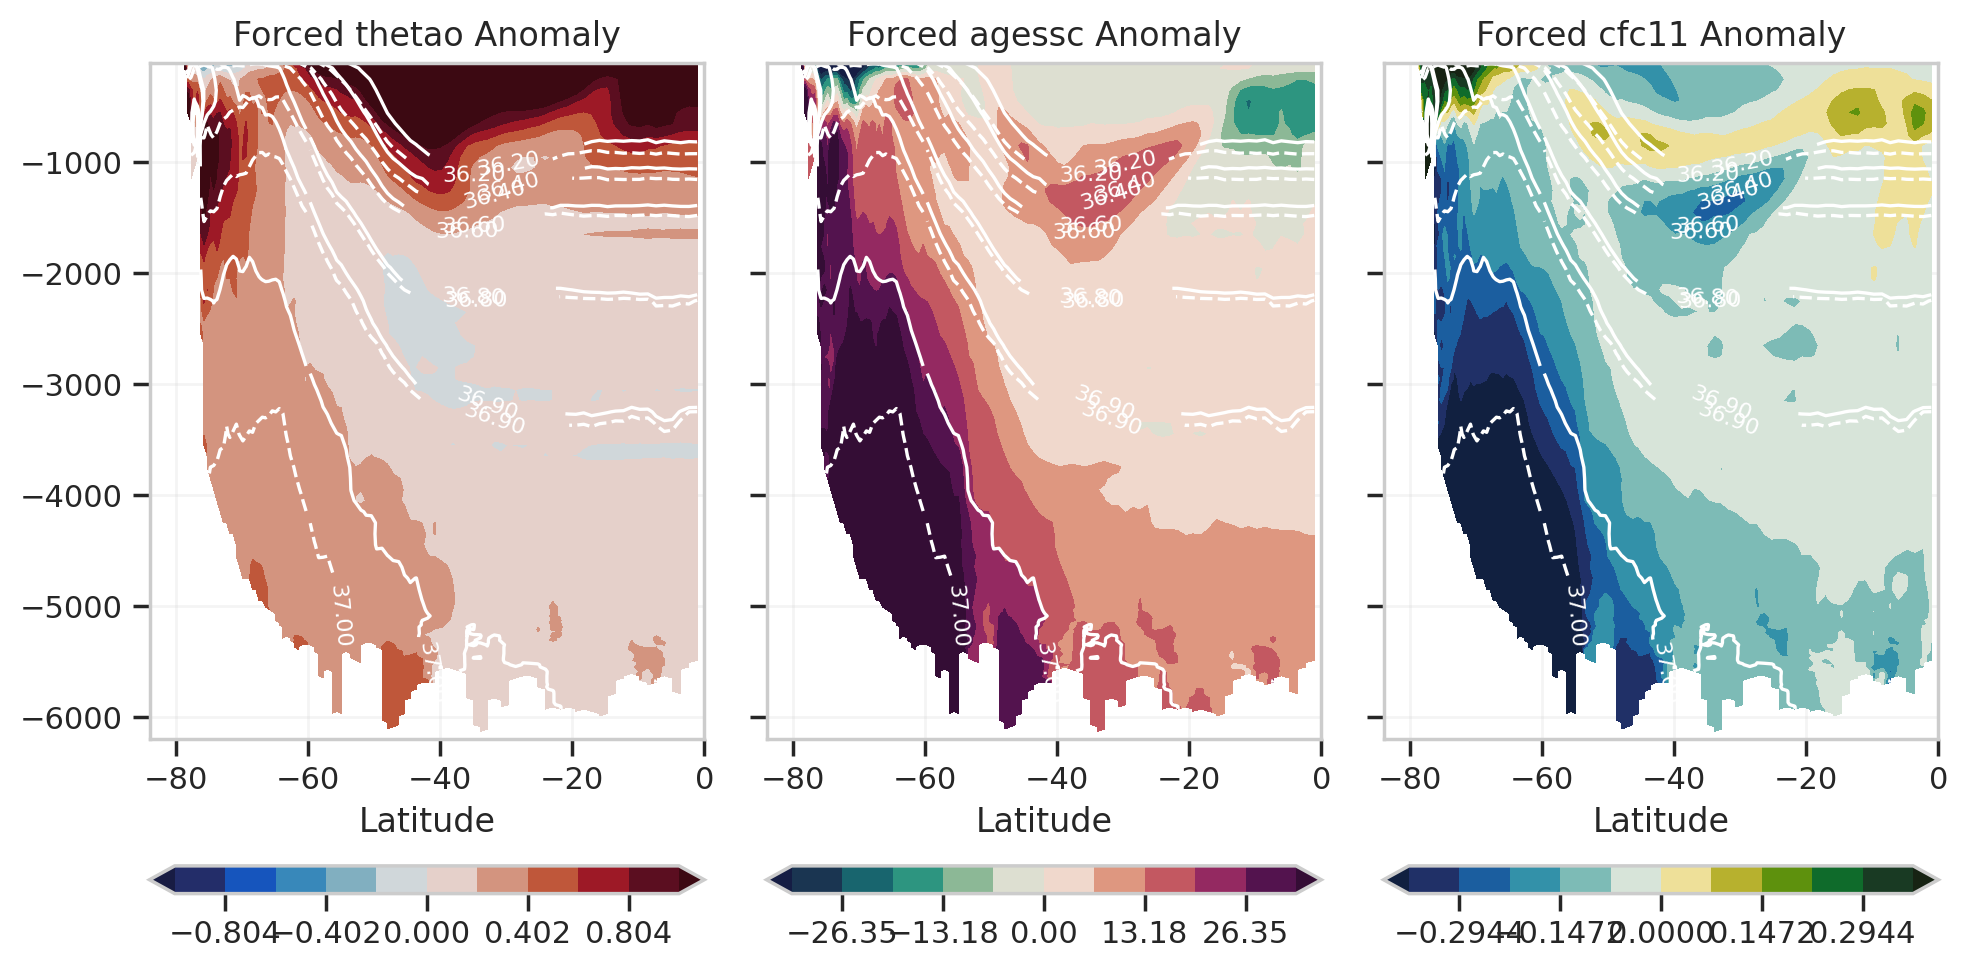

In [110]:
# Example usage:
fig, axes = plt.subplots(1, 3, figsize=(10, 5), sharey = True)

varns = ["thetao", "agessc", "cfc11"]
cmaps = [cmo.balance, cmo.curl, cmo.delta]
clabel_fontsize = 8
for (i, ax) in enumerate(axes):
    cf, control_contour, forced_contour = plot_difference(varns[i], ax, ds_forced_mean, ds_ctrl_mean, 
                                                          cmap = cmaps[i], max_scaling = 0.3)
    
    fig.colorbar(cf, ax = ax, orientation="horizontal", fraction = 0.05)
    ax.clabel(control_contour, inline=True, fontsize=clabel_fontsize, 
              levels=siglevels, colors='white')
    ax.clabel(forced_contour, inline=True, fontsize=clabel_fontsize, 
              levels=siglevels, colors='white')
    # Set plot limits and styling
    ax.set_xlim(None, 0)
    ax.set_ylim(-6200, -100)
    ax.grid(alpha=0.2)
    ax.tick_params(bottom=True, left=True)
    
    # Add labels
    ax.set_xlabel('Latitude')
    # ax.set_ylabel('Depth (m)')
    ax.set_title(f'Forced {varns[i]} Anomaly')
    
fig.tight_layout()